# Grammatical Error Correction with T5 (Seq2Seq Fine-tuning)

This notebook fine-tunes **T5-small** for **Grammatical Error Correction (GEC)**: given a noisy sentence (input), the model generates a corrected sentence (target). The workflow is: load and inspect the dataset, run lightweight dataset/feature analysis, tokenize for seq2seq training, fine-tune T5 with Hugging Face Trainer, and evaluate with both *standard text metrics* (BLEU/chrF) and *edit-based diagnostics* (edit-distance distributions, improvement vs baseline, copy behavior, and error analysis).

The goal is not only to maximize a single score, but to understand *how* the model edits: when it improves, when it regresses, and whether it under-corrects (copies too much) or over-corrects (unnecessary edits).


In [ ]:
!pip install -q transformers datasets evaluate sentencepiece sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00


## Environment & Reproducibility

We use Hugging Face Transformers/Datasets for training, and Evaluate for standardized metrics. To keep runs comparable across experiments, it’s important to fix random seeds (where possible) and log hyperparameters (batch size, epochs, max lengths, beam search settings). GPU acceleration (A100) is used for faster training/inference and enabling larger batch sizes.


In [ ]:
import numpy as np
import torch
import random
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Better: separate max lengths (you can keep one if you want)
MAX_SOURCE_LENGTH = 256
MAX_TARGET_LENGTH = 256
MAX_LENGTH = 256 # Defined MAX_LENGTH for tokenization

# Batch: keep conservative by default; we’ll scale per GPU
BATCH_SIZE = 16

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os

## Dataset

We train on a paired dataset of *(input, output)* where:

- **input**: noisy / uncorrected sentence  
- **output**: corrected target sentence

At a high level, this is a supervised sequence-to-sequence task: the model learns to “translate” noisy text into corrected text. Before training, we quickly inspect distributional properties (lengths, noise/edit density) so later evaluation plots have context.


In [ ]:
dataset = load_dataset("hafidikhsan/c4_200m-gec-train100k-test25k")
print(dataset)
print(dataset["train"][0])

README.md:   0%|          | 0.00/555 [00:00<?, ?B/s]

data/train-00000-of-00001-44bfcc14e6298a(…):   0%|          | 0.00/20.5M [00:00<?, ?B/s]

data/test-00000-of-00001-d91ef4657582798(…):   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'length_input', 'length_output'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input', 'output', 'length_input', 'length_output'],
        num_rows: 25000
    })
})
{'input': 'Bitcoin is for $7,094 this morning, which CoinDesk says.', 'output': 'Bitcoin goes for $7,094 this morning, according to CoinDesk.', 'length_input': 9, 'length_output': 9}


In [ ]:
from datasets import DatasetDict

raw = dataset  # keep original

train_full = raw["train"]
test_ds = raw["test"]

split = train_full.train_test_split(test_size=0.1, seed=SEED)
train_ds = split["train"]
val_ds = split["test"]  # rename: this becomes validation

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

print(dataset)
print("val example:", dataset["validation"][0])

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'length_input', 'length_output'],
        num_rows: 90000
    })
    validation: Dataset({
        features: ['input', 'output', 'length_input', 'length_output'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input', 'output', 'length_input', 'length_output'],
        num_rows: 25000
    })
})
val example: {'input': 'Thanks to Lennert Buytenhek writing for the patch.', 'output': 'Thanks to Lennert Buytenhek for the patch.', 'length_input': 8, 'length_output': 7}


In [ ]:
# Dataset sizes
print("Train size:", len(dataset["train"]))
print("Validation size:", len(dataset["validation"]))
print("Test size:", len(dataset["test"]))

Train size: 90000
Validation size: 10000
Test size: 25000


In [ ]:
# Sanity check: recompute and compare (all splits)
def check_lengths(example):
    return {
        "recalc_input_len": len(example["input"].split()),
        "recalc_output_len": len(example["output"].split())
    }

for split in ["train", "validation", "test"]:
    checked = dataset[split].map(check_lengths)

    assert all(
        checked[i]["recalc_input_len"] == checked[i]["length_input"]
        for i in range(min(100, len(checked)))
    )

    assert all(
        checked[i]["recalc_output_len"] == checked[i]["length_output"]
        for i in range(min(100, len(checked)))
    )

print("Length features verified (train/validation/test)")


Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Length features verified (train/validation/test)


## Quick Data Profiling (why this matters)

Before training, we do lightweight profiling to understand what “difficulty” looks like in this dataset. Typical signals include sentence length, how much the input differs from the target (edit distance / edit density), and surface noise patterns (punctuation, digits, casing, etc.).

This section is not used directly by T5 (unless explicitly engineered into the text), but it helps interpret results later—for example, whether the model performs worse on “hard” examples that require many edits.


In [ ]:
def length_delta(example):
    return {
        "length_delta": abs(example["length_input"] - example["length_output"])
    }

for split in ["train", "validation", "test"]:
    dataset[split] = dataset[split].map(length_delta)

Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
def char_noise_features(example):
    text = example["input"]
    return {
        "char_len": len(text),
        "digit_ratio": sum(c.isdigit() for c in text) / max(len(text), 1),
        "punct_ratio": sum(c in ".,;:$" for c in text) / max(len(text), 1)
    }

for split in ["train", "validation", "test"]:
    dataset[split] = dataset[split].map(char_noise_features)


Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
def edit_density(example):
    edits = sum(
        1 for a, b in zip(example["input"], example["output"]) if a != b
    )
    return {"edit_density": edits / max(len(example["input"]), 1)}

for split in ["train", "validation", "test"]:
    dataset[split] = dataset[split].map(edit_density)


Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
print("Avg input length:", np.mean(dataset["train"]["length_input"]))
print("Avg output length:", np.mean(dataset["train"]["length_output"]))
print("Max input length:", max(dataset["train"]["length_input"]))


Avg input length: 21.998255555555556
Avg output length: 21.876655555555555
Max input length: 400


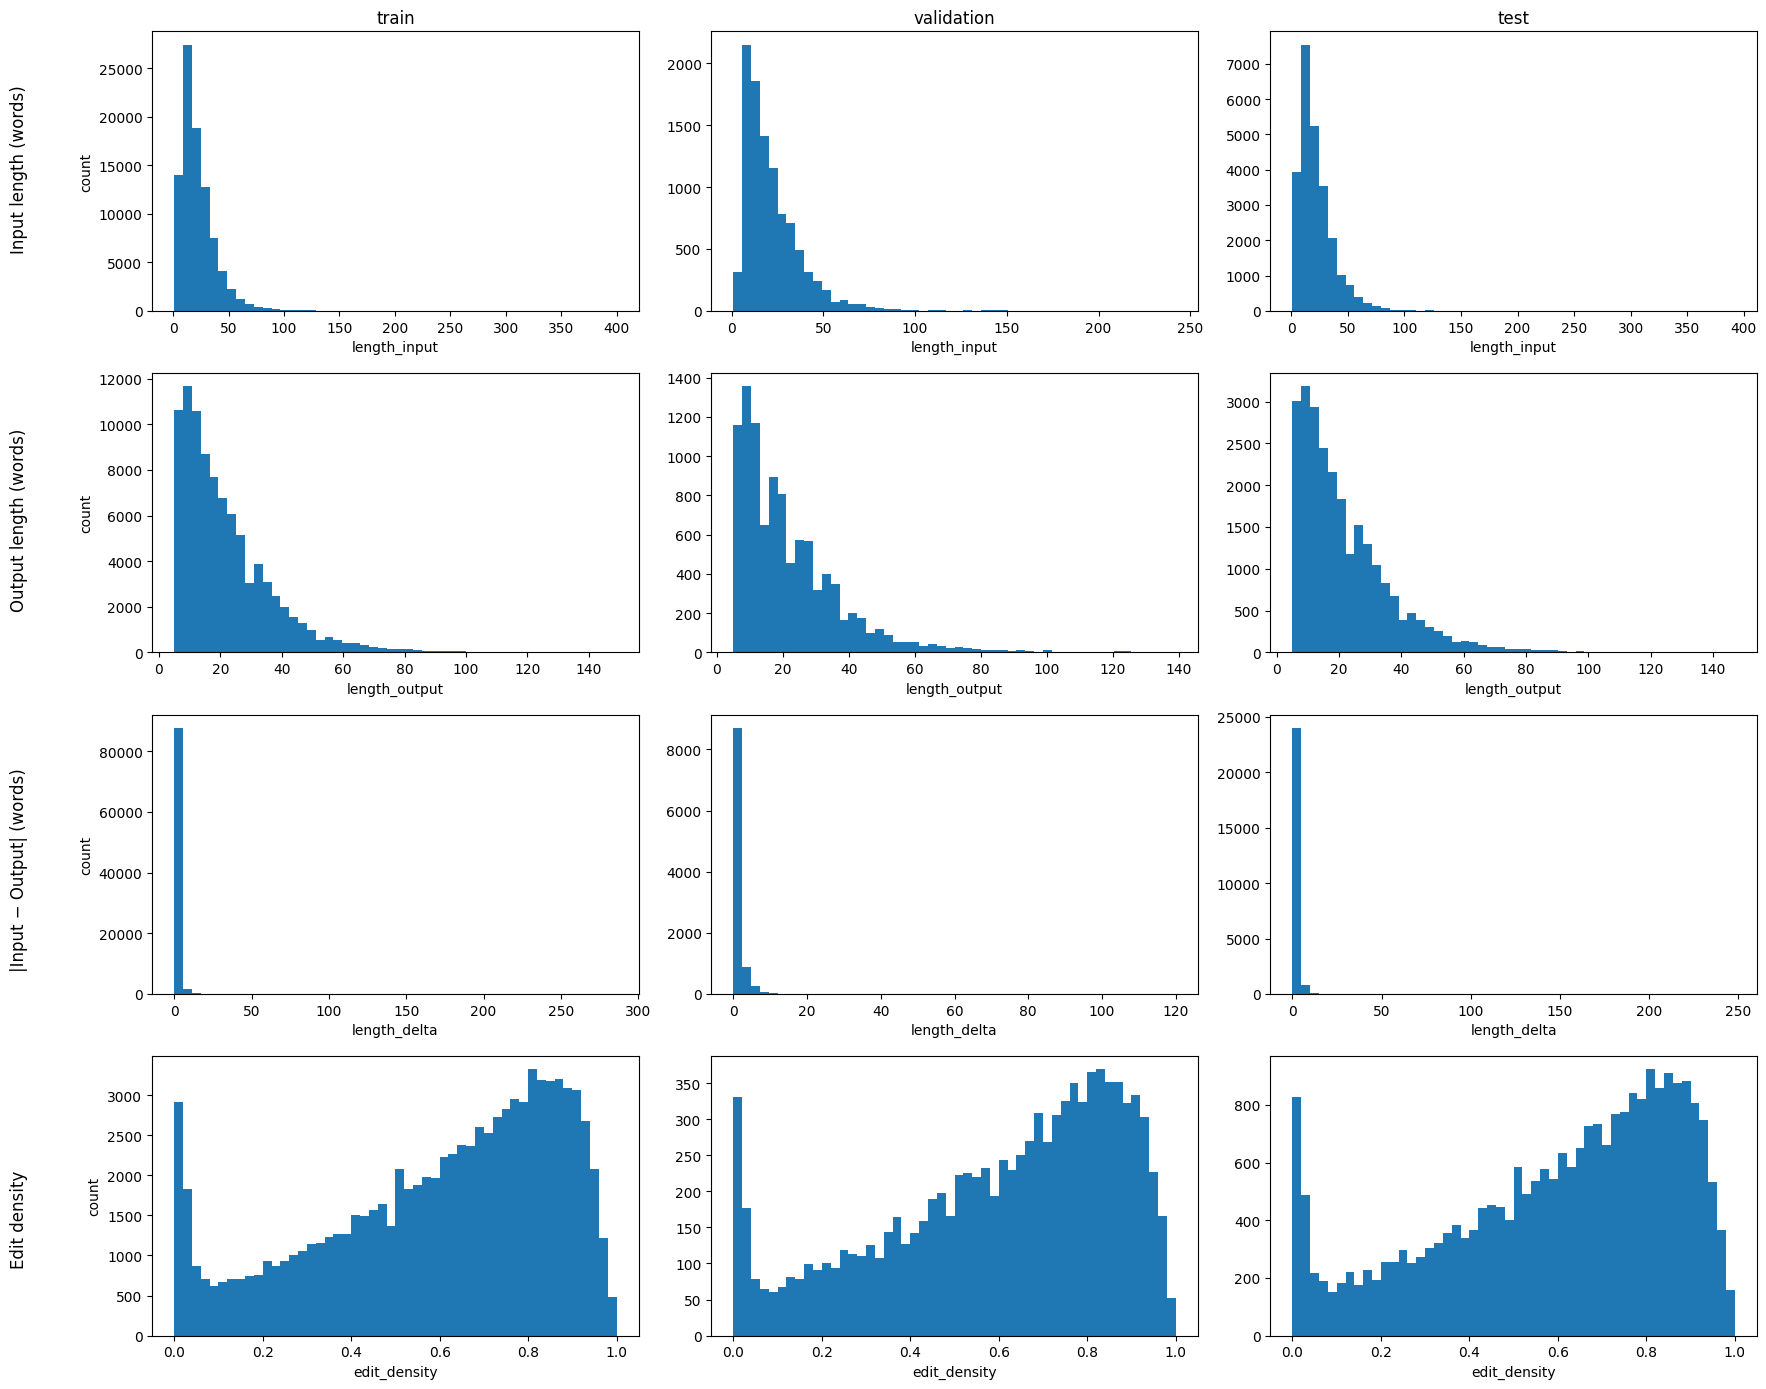

In [ ]:
splits = ["train", "validation", "test"]  # columns
metrics = [
    ("length_input",  "Input length (words)"),
    ("length_output", "Output length (words)"),
    ("length_delta",  "|Input − Output| (words)"),
    ("edit_density",  "Edit density"),
]  # rows

bins = 50
nrows, ncols = len(metrics), len(splits)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 14))

# Column titles once (top row)
for c, split in enumerate(splits):
    axes[0, c].set_title(split)

for r, (col, row_label) in enumerate(metrics):
    for c, split in enumerate(splits):
        ax = axes[r, c]
        ds = dataset[split]

        if col in ds.column_names:
            ax.hist(ds[col], bins=bins)
            ax.set_xlabel(col)
            ax.set_ylabel("count" if c == 0 else "")  # only left column shows y-label
        else:
            ax.axis("off")
            ax.text(0.5, 0.5, f"missing: {col}", ha="center", va="center", transform=ax.transAxes)

    # Put the row label on the *figure* (left margin), centered for that row
    y = 1 - (r + 0.5) / nrows
    fig.text(0.02, y, row_label, va="center", rotation=90, fontsize=12)

# Leave space on the left for row labels
plt.tight_layout(rect=[0.05, 0.0, 1.0, 1.0])
plt.show()


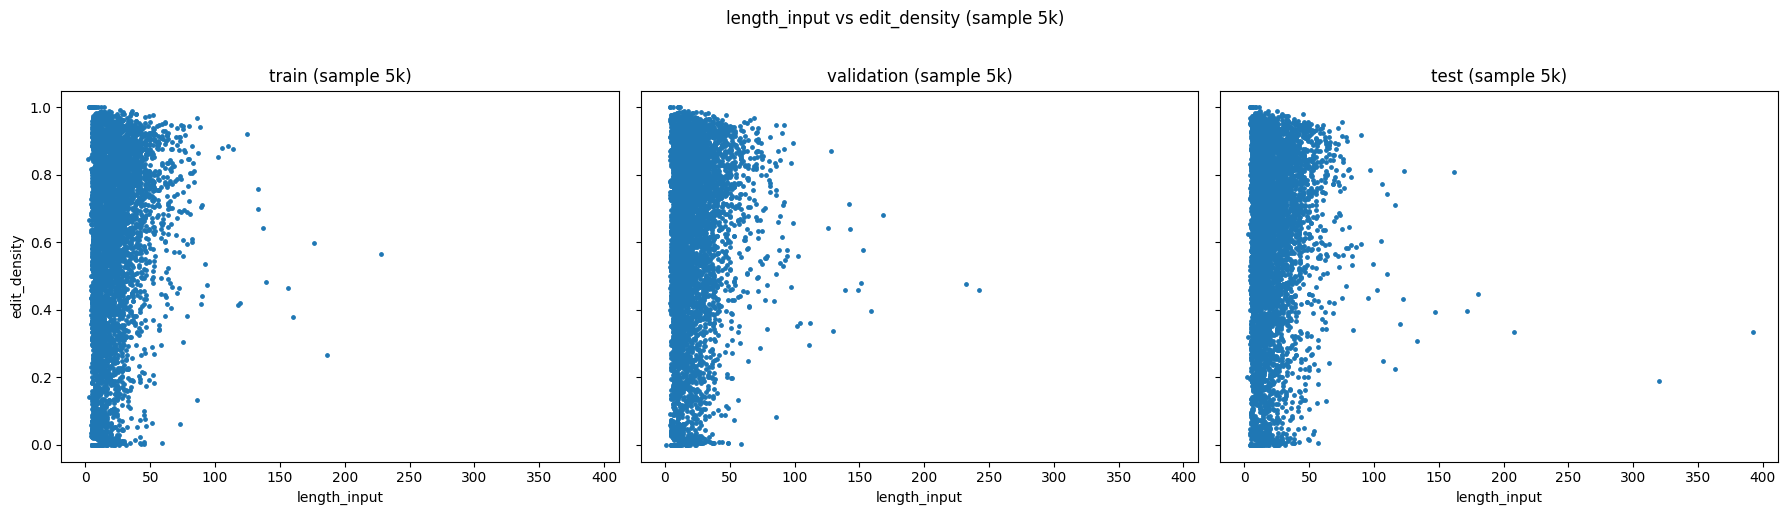

In [ ]:
splits = ["train", "validation", "test"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for i, split in enumerate(splits):
    ax = axes[i]
    ds = dataset[split]

    if "edit_density" not in ds.column_names:
        ax.axis("off")
        ax.set_title(f"{split} (missing edit_density)")
        continue

    x = np.array(ds["length_input"][:5000])
    y = np.array(ds["edit_density"][:5000])

    ax.scatter(x, y, s=6)
    ax.set_title(f"{split} (sample 5k)")
    ax.set_xlabel("length_input")
    if i == 0:
        ax.set_ylabel("edit_density")

plt.suptitle("length_input vs edit_density (sample 5k)", y=1.02)
plt.tight_layout()
plt.show()


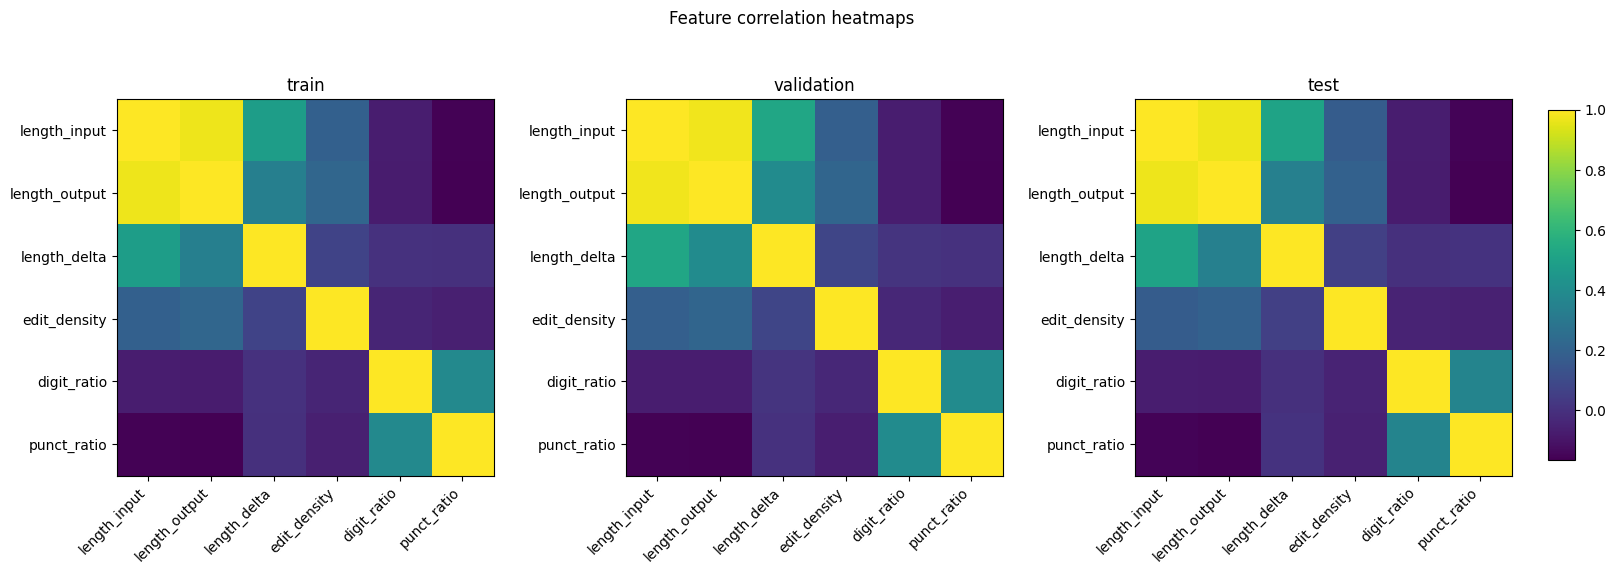

In [ ]:
splits = ["train", "validation", "test"]

cols = ["length_input", "length_output", "length_delta", "edit_density", "digit_ratio", "punct_ratio"]
cols = [c for c in cols if c in dataset["train"].column_names]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Leave space on the right for colorbar
fig.subplots_adjust(right=0.90, wspace=0.35)

im = None
for i, split in enumerate(splits):
    ax = axes[i]
    ds = dataset[split]

    X = np.vstack([ds[c] for c in cols]).T.astype(float)
    C = np.corrcoef(X, rowvar=False)

    im = ax.imshow(C)
    ax.set_title(split)
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha="right")
    ax.set_yticklabels(cols)

# Dedicated colorbar axis (no overlap)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.70])  # [left, bottom, width, height]
fig.colorbar(im, cax=cax)

fig.suptitle("Feature correlation heatmaps", y=1.05)
plt.show()


### Interpreting the profiling visuals

Length plots show whether the dataset is dominated by short sentences or has a heavy tail (long sentences). Heavy tails matter because max token limits can truncate examples and make the task harder.

Correlation-style plots are mainly sanity checks: they help confirm that “harder” examples (higher edit density / larger input-target gap) tend to align with larger normalized edit distances later. The takeaway I want from this section is: the dataset contains a mixture of low-edit and high-edit examples, and evaluation should reflect both.


## Tokenization & Seq2Seq Formatting

T5 is trained in a text-to-text format, so we tokenize the **input** as the encoder sequence and the **output** as the decoder target sequence. We also apply a task prefix (e.g., `correct:`) so the model consistently learns the intended task.

Important details:
- Inputs and targets are truncated/padded to fixed max lengths for batching.
- Labels use the standard seq2seq convention (padding positions are ignored in loss).
- This step defines what the model *actually sees*, so max lengths and truncation can strongly affect performance.


In [ ]:
model_id = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)

TASK_PREFIX = "correct: "  # T5 works better with a task prefix

def preprocess_function(batch):
    inputs = [TASK_PREFIX + x for x in batch["input"]]
    targets = batch["output"]

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_SOURCE_LENGTH,
        truncation=True,
    )

    labels = tokenizer(
        text_target=targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,  # removes input/output/length_*
)

tokenized_dataset


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 90000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
})

In [ ]:
train_dataset = tokenized_dataset["train"]
eval_dataset  = tokenized_dataset["validation"]
test_dataset  = tokenized_dataset["test"]  # keep for final eval later

print(len(train_dataset))
print(len(eval_dataset))
print(len(test_dataset))


90000
10000
25000


### Note on splits and sizes

After preprocessing, we have train/validation/test splits ready for the Trainer loop. The validation split is used for checkpoint selection (“best model”) and early diagnostics, while the held-out test split is used for final reporting only.


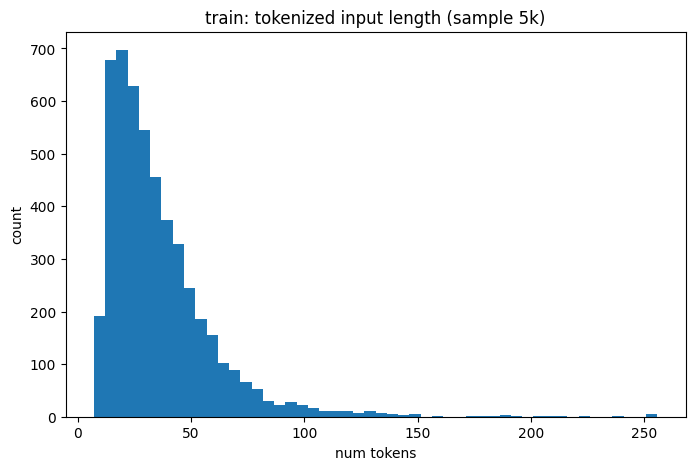

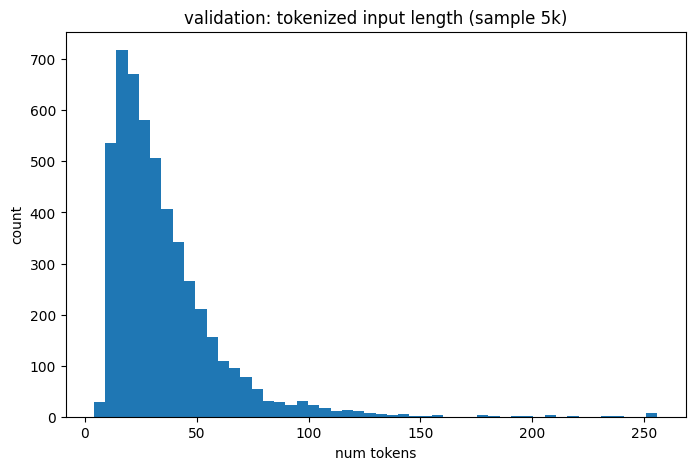

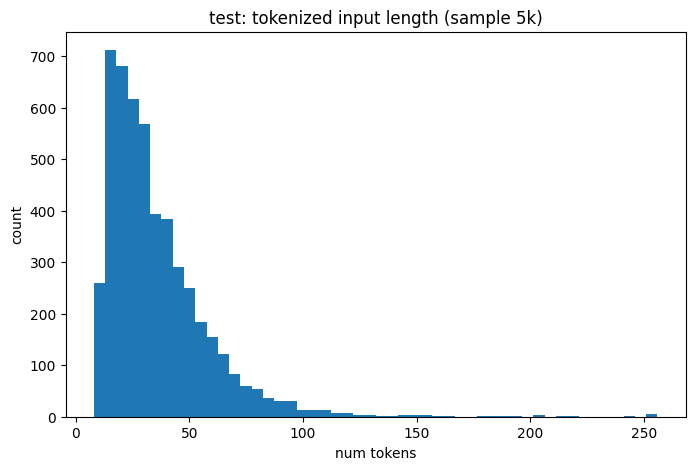

In [ ]:
def get_tok_lens(ds, n=5000):
    lens = []
    for i in range(min(n, len(ds))):
        lens.append(len(ds[i]["input_ids"]))
    return np.array(lens)

for split in ["train", "validation", "test"]:
    lens = get_tok_lens(tokenized_dataset[split], n=5000)
    plt.figure(figsize=(8,5))
    plt.hist(lens, bins=50)
    plt.title(f"{split}: tokenized input length (sample 5k)")
    plt.xlabel("num tokens")
    plt.ylabel("count")
    plt.show()

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
model.to(device)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Model & Training Setup

We fine-tune **T5-small** using cross-entropy loss on the decoder outputs. The Trainer handles batching, mixed precision, evaluation, checkpointing, and best-model selection.

Key training choices (high-level):
- Batch size and epochs control how much data the model sees.
- Evaluation/checkpoint strategy ensures we can select the best checkpoint by validation loss.
- Mixed precision (fp16) speeds up training on GPUs like A100 without changing the objective.

Because this is a generation task, we later evaluate with generation-based metrics (BLEU/chrF) and edit-based metrics rather than relying only on training loss.


In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

num_epochs = 10

training_args = TrainingArguments(
    output_dir="t5_gec_run",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,   # effective batch = BATCH_SIZE * 4
    num_train_epochs=num_epochs,
    learning_rate=5e-5,
    warmup_ratio=0.05,
    bf16=True,
    fp16=False,
    logging_strategy="steps",
    logging_steps=100,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    save_total_limit=2,
    report_to="none",
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [ ]:
train_result = trainer.train()

save_path = "/content/drive/MyDrive/t5-small-gec-finetuned-10"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\nModel saved to: {os.path.abspath(save_path)}")
print("Folder contains:", os.listdir(save_path))
print("Save successful:", os.path.exists(save_path))


Epoch,Training Loss,Validation Loss
1,0.818500,0.729691
2,0.763900,0.711598
3,0.743700,0.696649
4,0.746000,0.691648
5,0.743100,0.686509
6,0.716600,0.681693
7,0.710500,0.681229
8,0.714700,0.678746
9,0.697900,0.679527
10,0.706400,0.679091


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Model saved to: /content/drive/MyDrive/t5-small-gec-finetuned-10
Folder contains: ['config.json', 'generation_config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'spiece.model', 'tokenizer.json', 'training_args.bin']
Save successful: True


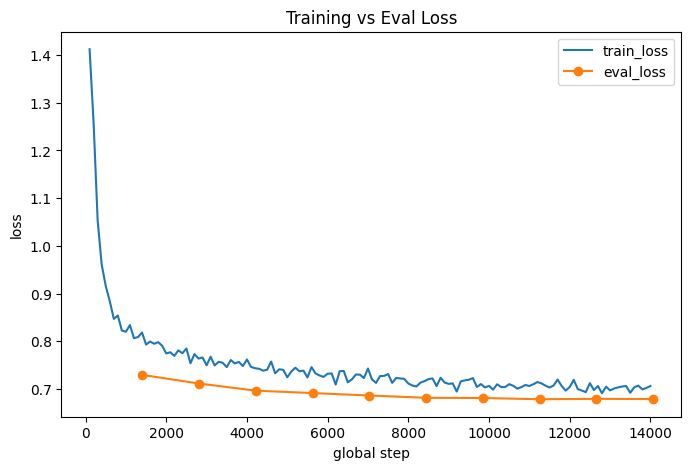

In [ ]:
logs = trainer.state.log_history

train_steps = [x["step"] for x in logs if "loss" in x and "step" in x]
train_losses = [x["loss"] for x in logs if "loss" in x and "step" in x]

eval_steps = [x["step"] for x in logs if "eval_loss" in x and "step" in x]
eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x and "step" in x]

plt.figure(figsize=(8,5))
plt.plot(train_steps, train_losses, label="train_loss")
plt.plot(eval_steps, eval_losses, label="eval_loss", marker="o")
plt.xlabel("global step")
plt.ylabel("loss")
plt.legend()
plt.title("Training vs Eval Loss")
plt.show()


## Training Curve: what to look for

The training loss typically drops quickly early on and then tapers as the model converges. The validation loss is the key signal for generalization: a steady decrease suggests learning; a flat or rising curve can indicate saturation or overfitting.

In this run, the best checkpoint is selected based on the lowest validation loss (logged by the Trainer), which is a reasonable default selection criterion for seq2seq fine-tuning.


In [ ]:
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Best eval_loss:", trainer.state.best_metric)

Best checkpoint: t5_gec_run/checkpoint-11256
Best eval_loss: 0.6787460446357727


In [ ]:
eval_results = trainer.evaluate()
print("Validation results:", eval_results)

Validation results: {'eval_loss': 0.6787460446357727, 'eval_runtime': 17.3899, 'eval_samples_per_second': 575.045, 'eval_steps_per_second': 35.94, 'epoch': 10.0}


In [ ]:
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test results:", test_results)

Test results: {'eval_loss': 0.672654926776886, 'eval_runtime': 43.7919, 'eval_samples_per_second': 570.882, 'eval_steps_per_second': 35.692, 'epoch': 10.0}


### Validation/Test loss

We report both validation and test loss for completeness. Validation loss is used during training for model selection; test loss is a final sanity check that performance generalizes similarly on held-out data.

Also note: throughput metrics (samples/sec, steps/sec) are reported to document runtime performance under the chosen hardware and batch sizes.


In [ ]:
from tqdm import tqdm

model = trainer.model
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

## Generation (Decoding) Configuration

Loss is computed with teacher forcing during training, but evaluation for GEC is ultimately about the quality of *generated text*. We therefore define decoding settings and generate predictions for the test set.

We use beam search with conservative constraints (e.g., no-repeat ngram) to reduce degenerate repetition and stabilize output quality. Decoding choices can change BLEU/chrF and also affect edit behavior (how aggressively the model rewrites).

In [ ]:
gen_kwargs = dict(
    num_beams=4,
    max_new_tokens=MAX_TARGET_LENGTH,
    length_penalty=1.0,
    early_stopping=True,
    no_repeat_ngram_size=3,
)


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def batched_generate(dataset, batch_size=8, gen_kwargs=None, num_workers=0):
    gen_kwargs = gen_kwargs or {}
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=data_collator,
        num_workers=num_workers,
        pin_memory=True,
    )

    preds, labels = [], []
    model = trainer.model
    tok = tokenizer

    for batch in tqdm(loader):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                **gen_kwargs
            )

        preds.extend(tok.batch_decode(outputs, skip_special_tokens=True))

        label_ids = torch.where(
            batch["labels"] != -100,
            batch["labels"],
            tok.pad_token_id
        )
        labels.extend(tok.batch_decode(label_ids, skip_special_tokens=True))

    return preds, labels

In [ ]:
import evaluate

test_dataset = tokenized_dataset["test"]

bleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")

trainer.model.eval()

pred_texts, label_texts = batched_generate(
    test_dataset,
    batch_size=32 if torch.cuda.is_available() else 2,
    gen_kwargs=gen_kwargs,
    num_workers=0,
)

bleu_score = bleu.compute(predictions=pred_texts, references=[[x] for x in label_texts])["score"]
chrf_score = chrf.compute(predictions=pred_texts, references=[[x] for x in label_texts])["score"]

print("BLEU (sacrebleu):", bleu_score)
print("chrF:", chrf_score)

exact_match = np.mean([p.strip() == g.strip() for p, g in zip(pred_texts, label_texts)])
print("Exact Match (secondary):", exact_match)

raw_inputs = dataset["test"]["input"]  # NOTE: raw (non-tokenized) dataset
copy_rate = np.mean([p.strip() == i.strip() for p, i in zip(pred_texts, raw_inputs)])
print("Copy rate (pred == input):", copy_rate)


100%|██████████| 782/782 [56:52<00:00,  4.36s/it]


BLEU (sacrebleu): 68.21008675984946
chrF: 84.04193559448461
Exact Match (secondary): 0.06268
Copy rate (pred == input): 0.22576


In [ ]:
assert len(pred_texts) == len(raw_inputs), (len(pred_texts), len(raw_inputs))

In [ ]:
import editdistance

edit_dists = np.array([editdistance.eval(p, g) for p, g in zip(pred_texts, label_texts)])
norm_edit = np.array([d / max(1, len(g)) for d, g in zip(edit_dists, label_texts)])

print("Average Edit Distance:", edit_dists.mean())
print("Normalized Edit Distance (per target char):", norm_edit.mean())

Average Edit Distance: 16.95908
Normalized Edit Distance (per target char): 0.13816571738820393


## Final Metrics (Test Set)

We report both **surface-form similarity** metrics and **edit-based** diagnostics:

BLEU and chrF summarize overlap with the target at different granularities (BLEU is more precision-oriented; chrF is character n-gram based and often more forgiving for GEC). Exact Match is reported as a *secondary* metric because it is extremely strict—many corrections can be acceptable without matching the reference character-for-character.

Copy rate measures how often the model outputs exactly the input. In a dataset where most inputs contain errors, a high copy rate can indicate **under-correction**. Edit distance (and normalized edit distance per target character) quantifies how far predictions are from targets in an interpretable “number of edits” sense.

For this run, the test-set results were:
- BLEU (sacrebleu): **68.21**
- chrF: **84.04**
- Exact Match (secondary): **0.0627**
- Copy rate: **0.2258**
- Average edit distance: **16.96**
- Normalized edit distance: **0.1382**

A useful mental model here: BLEU/chrF capture *text similarity*, while the edit-based metrics and copy behavior capture *editing strategy* and help explain failure modes.


In [ ]:
import json, os

out_dir = "/content/drive/MyDrive/t5-small-gec-finetuned/gec_eval"
os.makedirs(out_dir, exist_ok=True)

with open(os.path.join(out_dir, "pred_texts.txt"), "w") as f:
    f.write("\n".join(pred_texts))

with open(os.path.join(out_dir, "label_texts.txt"), "w") as f:
    f.write("\n".join(label_texts))

metrics = {
    "bleu_sacrebleu": bleu_score,
    "chrf": chrf_score,
    "exact_match_secondary": float(exact_match),
    "copy_rate": float(copy_rate),
    "gen_kwargs": gen_kwargs,
}
with open(os.path.join(out_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved outputs + metrics to:", out_dir)


Saved outputs + metrics to: /content/drive/MyDrive/t5-small-gec-finetuned/gec_eval


## Edit Distance Distributions + Improvement vs Baseline

To understand whether the model truly improves noisy inputs, we compare:
- **baseline**: edit distance between *(input, target)*
- **model**: edit distance between *(prediction, target)*

We plot:
- a zoomed histogram (0 to P95) to show the “typical” range clearly,
- a full-range histogram with log-scaled counts to expose long-tail outliers,
- an **improvement histogram** of Δ = (baseline − model), where **positive means the model reduced edit distance** relative to the raw input.

These plots complement BLEU/chrF by showing *how much* the model moves predictions toward the target in edit space, and whether gains are broad or concentrated in a subset of examples.

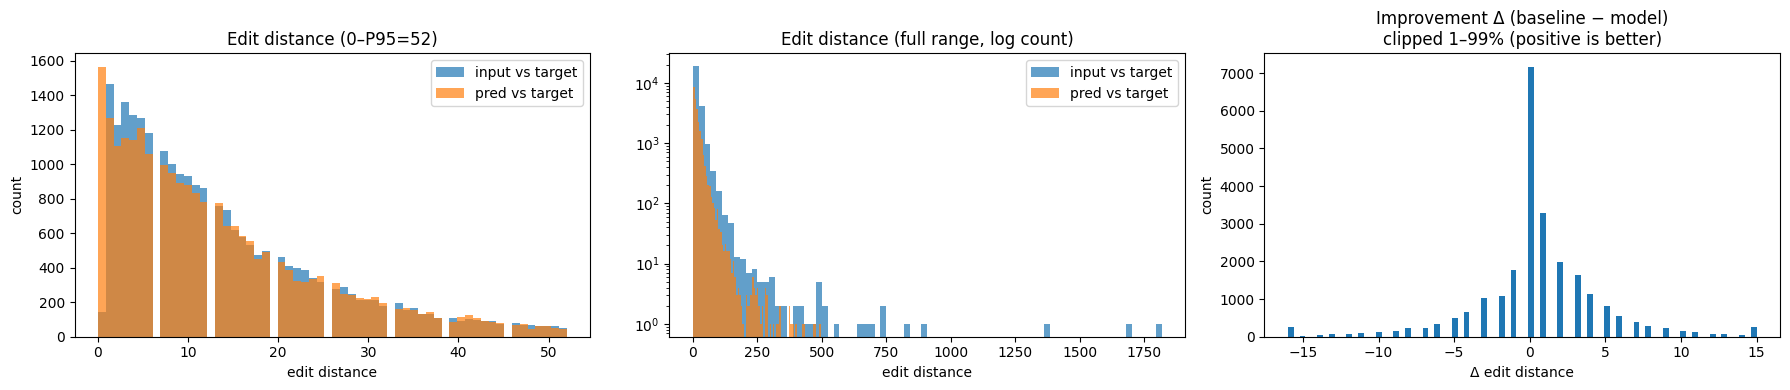

In [ ]:
raw_inputs = dataset["test"].select(range(len(pred_texts)))["input"]

base_dist = np.array([editdistance.eval(i, g) for i, g in zip(raw_inputs, label_texts)])
pred_dist = np.array([editdistance.eval(p, g) for p, g in zip(pred_texts, label_texts)])
improve = base_dist - pred_dist  # positive = model improved vs noisy input

all_vals = np.concatenate([base_dist, pred_dist])
zoom_max = int(np.percentile(all_vals, 95))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Zoomed distributions (0..P95)
axes[0].hist(base_dist, bins=60, alpha=0.7, label="input vs target", range=(0, zoom_max))
axes[0].hist(pred_dist, bins=60, alpha=0.7, label="pred vs target", range=(0, zoom_max))
axes[0].set_title(f"Edit distance (0–P95={zoom_max})")
axes[0].set_xlabel("edit distance")
axes[0].set_ylabel("count")
axes[0].legend()

# Full-range distributions with log-count (tail visible)
axes[1].hist(base_dist, bins=80, alpha=0.7, label="input vs target")
axes[1].hist(pred_dist, bins=80, alpha=0.7, label="pred vs target")
axes[1].set_yscale("log")
axes[1].set_title("Edit distance (full range, log count)")
axes[1].set_xlabel("edit distance")
axes[1].legend()

# Improvement histogram (clipped 1–99%)
lo, hi = np.percentile(improve, [1, 99])
axes[2].hist(np.clip(improve, lo, hi), bins=80)
axes[2].set_title("Improvement Δ (baseline − model)\nclipped 1–99% (positive is better)")
axes[2].set_xlabel("Δ edit distance")
axes[2].set_ylabel("count")

plt.tight_layout()
plt.show()


### How to read the improvement histogram

The improvement histogram can look “spiky” because edit distance is integer-valued and many examples cluster near small changes. A large mass near Δ≈0 typically means many examples are already close to the target (or the model’s correction doesn’t change the edit distance much). The right tail shows examples where the model clearly improves the noisy input; the left tail shows regressions where the model moves farther from the target.

Clipping to the 1–99% range is used here to make the central behavior readable without being dominated by extreme outliers.


## Copying vs Editing: diagnosing under/over-correction

Even strong GEC models can fail in two common ways:
- **Under-correction**: model copies input when edits are needed.
- **Over-correction**: model makes unnecessary edits when input is already correct.

To visualize this, we plot overall copy behavior (copied vs edited) and the distribution of how many characters the model changes when it edits (edit distance between prediction and input). Together, these plots describe the model’s “editing aggressiveness.”


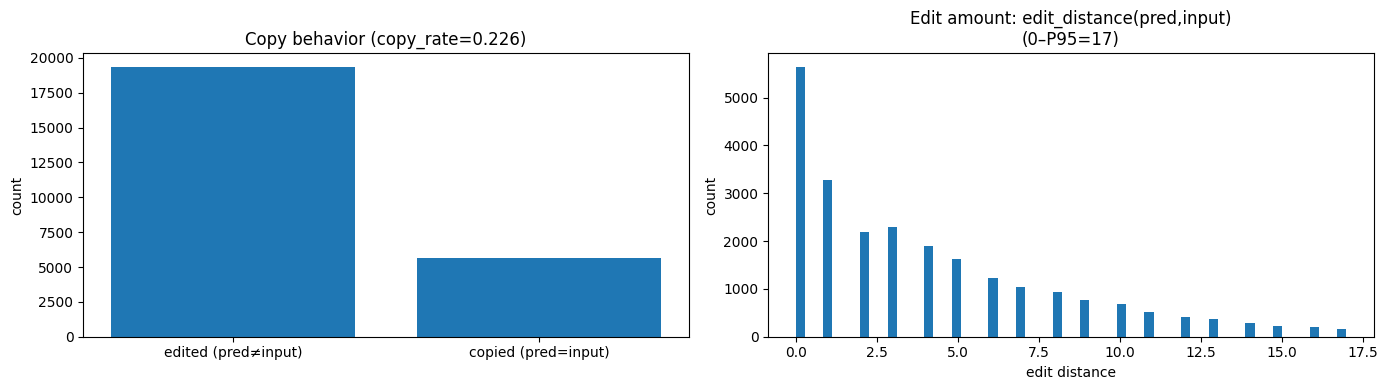

In [ ]:
# raw_inputs must align with pred_texts
raw_inputs = dataset["test"]["input"]  # for full test; use the matching slice if you evaluated on a subset

copy_mask = np.array([p.strip() == i.strip() for p, i in zip(pred_texts, raw_inputs)])
copy_rate = copy_mask.mean()

pred_vs_input = np.array([editdistance.eval(p, i) for p, i in zip(pred_texts, raw_inputs)])

# zoom for the histogram (most edits are small)
zoom_max = int(np.percentile(pred_vs_input, 95))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Copy rate bar (counts)
counts = np.bincount(copy_mask.astype(int), minlength=2)  # [not_copy, copy]
axes[0].bar(["edited (pred≠input)", "copied (pred=input)"], [counts[0], counts[1]])
axes[0].set_title(f"Copy behavior (copy_rate={copy_rate:.3f})")
axes[0].set_ylabel("count")

# How much the model edits (pred vs input)
axes[1].hist(pred_vs_input, bins=60, range=(0, zoom_max))
axes[1].set_title(f"Edit amount: edit_distance(pred,input)\n(0–P95={zoom_max})")
axes[1].set_xlabel("edit distance")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()


### Interpreting copy rate and edit-amount

A copy rate around ~0.23 means the model edits most inputs, but still leaves a non-trivial fraction unchanged. Whether that is good depends on how often the dataset truly needs corrections; this is why we additionally compute a behavior confusion matrix against the ground truth “needs_edit” signal in the next section.

The edit-amount distribution is expected to be heavily skewed toward small edits (punctuation, articles, minor grammar). A long tail indicates the presence of harder sentences where larger rewrites are required.


## Performance by difficulty & Behavior Confusion Matrix

To understand where the model struggles, we bucket examples by an estimated difficulty proxy (edit density) and compute the **average normalized edit distance** per bucket. This answers: *does the model degrade gracefully as examples require more edits?*

We also compute a behavior confusion matrix comparing:
- whether the example *needs an edit* (input ≠ target),
- whether the model *made an edit* (prediction ≠ input).

This breaks errors into under-corrections (missed edits) and over-corrections (unnecessary edits), which is often more actionable than a single aggregate score.


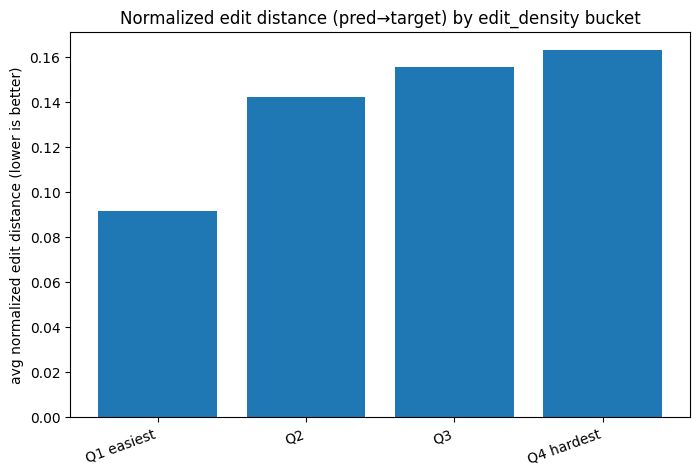

In [ ]:
raw_slice = dataset["test"].select(range(len(pred_texts)))
ed = np.array(raw_slice["edit_density"]) if "edit_density" in raw_slice.column_names else None

if ed is not None:
    qs = np.quantile(ed, [0.25, 0.5, 0.75])
    bins = [-1, qs[0], qs[1], qs[2], 1e9]
    names = ["Q1 easiest", "Q2", "Q3", "Q4 hardest"]

    # metric: normalized edit distance pred->target (lower is better)
    import editdistance
    pred_dist = np.array([editdistance.eval(p, g) / max(1, len(g)) for p, g in zip(pred_texts, label_texts)])

    bucket_means = []
    for b0, b1 in zip(bins[:-1], bins[1:]):
        idx = np.where((ed > b0) & (ed <= b1))[0]
        bucket_means.append(pred_dist[idx].mean() if len(idx) else np.nan)

    plt.figure(figsize=(8,5))
    plt.bar(names, bucket_means)
    plt.title("Normalized edit distance (pred→target) by edit_density bucket")
    plt.ylabel("avg normalized edit distance (lower is better)")
    plt.xticks(rotation=20, ha="right")
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

raw_inputs = dataset["test"]["input"]
raw_targets = dataset["test"]["output"]

needs_edit = np.array([i.strip() != t.strip() for i, t in zip(raw_inputs, raw_targets)]).astype(int)
model_edited = np.array([p.strip() != i.strip() for p, i in zip(pred_texts, raw_inputs)]).astype(int)

cm = confusion_matrix(needs_edit, model_edited, labels=[0, 1])
print("Behavior Confusion Matrix (rows=needs_edit, cols=model_edited):\n", cm)
print("TN(no edit needed, model no edit) =", cm[0,0])
print("FP(no edit needed, model edited)  =", cm[0,1], "  <-- overcorrections")
print("FN(edit needed, model no edit)    =", cm[1,0], "  <-- undercorrections")
print("TP(edit needed, model edited)     =", cm[1,1])


Behavior Confusion Matrix (rows=needs_edit, cols=model_edited):
 [[  108    45]
 [ 5536 19311]]
TN(no edit needed, model no edit) = 108
FP(no edit needed, model edited)  = 45   <-- overcorrections
FN(edit needed, model no edit)    = 5536   <-- undercorrections
TP(edit needed, model edited)     = 19311


### What the confusion matrix indicates

- **Undercorrections (FN)**: input needed edits but the model copied it. This is often the dominant failure mode in GEC because copying is “safe” under loss but hurts recall on errorful inputs.
- **Overcorrections (FP)**: input was already correct but the model edited anyway. This hurts precision and can reduce trust in predictions.

In this run, undercorrections are much larger than overcorrections, suggesting the model is generally conservative about rewriting when uncertain.

## Qualitative Examples

Metrics summarize average behavior, but qualitative inspection is essential for GEC. Here we print random examples to verify:
- corrections are grammatical and preserve meaning,
- punctuation and agreement fixes are sensible,
- failure cases align with what the diagnostics suggested (e.g., copying when an edit was needed, or making awkward rewrites).

When reviewing, I pay special attention to: dropped words, hallucinated substitutions, punctuation over-editing, and cases where multiple correct outputs exist but only one reference is provided.


In [ ]:
random.seed(42)

for j in random.sample(range(len(pred_texts)), k=20):
  print("idx:", j)
  print("\nINPUT  :", dataset["test"][j]["input"])
  print("PRED   :", pred_texts[j])
  print("TARGET :", label_texts[j])
  print("-" * 50)


idx: 20952

INPUT  : Lip augmentation costs an average of $850 but varies by procedure per Real Self and a cure with Dr. Dhir ranges from $800 to $1500 depending on the required amount amount of filler.
PRED   : Lip augmentation costs an average of $850 but varies by procedure per Real Self and a cure with Dr. Dhir ranges from $800 to $1500 depending on the required amount of filler.
TARGET : Lip augmentation costs an average of $850 but varies on the procedure, per Real Self and a treatment with Dr. Dhir ranges from $800 to $1500, depending on the amount of filler needed.
--------------------------------------------------
idx: 3648

INPUT  : People Who are Blind Can Hoop I’ll take the video for its’ self on this one but this could be really inspiring.
PRED   : People Who Are Blind Can Hoop. I’ll take the video for its’ self on this one but this could be really inspiring.
TARGET : People Who are Blind Can Hoop – I’ll let the video speak for its’ self on this one but this is really insp

In [ ]:
# show worst 10 cases by pred->target edit distance
worst = np.argsort(-pred_dist)[:10]
for k, j in enumerate(worst, 1):
    print(f"\n--- Worst #{k} idx={j} ---")
    print("INPUT :", raw_inputs[int(j)])
    print("PRED  :", pred_texts[int(j)])
    print("TARGET:", label_texts[int(j)])


--- Worst #1 idx=12318 ---
INPUT : L Exhaust Sensor gas (100 short distilleges per se = 1000 small distilledge gas sensor) ?
PRED  : L Exhaust Sensor gas (100 short distilleges per se = 1000 small distilled gas sensor)?
TARGET: 115 L Exhaust Gas Sensor (Oxygen Sensor)?

--- Worst #2 idx=17953 ---
INPUT : Papa W. Adams . , None . [Form 1855 to 1865] [Photograph] Retrieved from the Library of Congress, Arkmail.info Arcrich s.quo Arcrich atlantique: OCTL Arcrich atlantique: OCTLAR Arcrich atlantique: The Library of Congress 2005Aug 10 / 2005050451308560360/ puis a received by [ rps://www.loc.gov/item/2017895560/.
PRED  : Papa W. Adams., None. [Form 1855 to 1865] [Photograph] Retrieved from the Library of Congress, Arkmail.info. Arcrich s.quo. Atlantique: OCTL. Arcarich atlantique. OCTLAR. Arcal. Atlantis: The Library of congress 2005Aug 10 / 2005050451308560360/ puis received by [ rps://www.loc.gov/item/2017895560/.
TARGET: Rev. W. Adams., None. [Between 1855 and 1865] [Photograph] Retri

# Summary & Next Steps

This fine-tuned T5-small model achieves strong chrF and solid BLEU on the test set, with edit-distance diagnostics showing that improvements over the noisy baseline occur broadly (not just in a few cherry-picked cases). Copy-rate and the behavior confusion matrix indicate that the main remaining weakness is **undercorrection**: the model sometimes leaves sentences unchanged even when the target differs.

Next steps to push performance further would focus on reducing undercorrections (without increasing overcorrections). Practical options include tuning decoding to encourage minimal-but-necessary edits, training longer with careful regularization/early stopping, and adding targeted error analysis (e.g., performance by sentence length, by punctuation-heavy inputs, and by common grammar categories).
